<a href="https://colab.research.google.com/github/78furu/deeplea_adv/blob/master/deeplea_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/github_repos/deeplea_adv/'
%pwd

import unet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/github_repos/deeplea_adv


In [ ]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

print(f"Pytorch version: {torch.__version__}")

# Set the runtime environment to GPU in: Edit -> Notebook settings or Runtime -> Change runtime type  
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Seed random number generator
torch.manual_seed(0)
np.random.seed(0)

Pytorch version: 1.8.0+cu101
Using GPU device: Tesla T4


In [ ]:
net = unet.unet_model.UNet(n_channels=3, n_classes=10)
net.input_size=(3, 32, 32)
net.num_classes = 10
MODEL = net.to(torch.cuda.current_device())


In [ ]:
summary(MODEL, MODEL.input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [25]:
def load_and_preprocess_data(dataset_name, batch_size, augment=False):
    """Load, preprocess and return data for training and testing.
    
    Args:
        dataset_name: str, name of dataset from {'mnist', 'cifar10'}.
        batch_size: int, batch size used for training and testing.
        augment: bool, if True, apply data augmentation defined by the augmentation transforms.
    Returns:
        Training and test dataloader objects.
    """

    # Define transformations that will be appied to images
    train_transforms = transforms.Compose([transforms.ToTensor()])
    test_transforms = transforms.Compose([transforms.ToTensor()])

    if augment is True:
        augmentation_transforms = [transforms.RandomCrop(32, padding=4),
                                   transforms.RandomHorizontalFlip(), 
                                   transforms.RandomGrayscale(),
                                   transforms.GaussianBlur((3,3)),
                                   transforms.RandomRotation(np.random.uniform(low=-3.14, high=3.14))]
        train_transforms = transforms.Compose(augmentation_transforms + [transforms.ToTensor()])
        
    # Load train and test datasets
    if dataset_name == 'mnist':
        train_dataset = torchvision.datasets.MNIST(root='./data', 
                                                   train=True,
                                                   download=True, 
                                                   transform=train_transforms)
        test_dataset = torchvision.datasets.MNIST(root='./data', 
                                                  train=False,
                                                  download=True, 
                                                  transform=test_transforms)
    elif dataset_name == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                                     train=True,
                                                     download=True, 
                                                     transform=train_transforms)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                                    train=False,
                                                    download=True, 
                                                    transform=test_transforms)
    else:
        raise Exception("The dataset name must be element of {'mnist', 'cifar10'}.")

    # Create dataset loaders
    trainset_loader = torch.utils.data.DataLoader(train_dataset, 
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=2)
    testset_loader = torch.utils.data.DataLoader(test_dataset, 
                                                 batch_size=batch_size,
                                                 shuffle=False, 
                                                 num_workers=2)

    # Print data info
    print(f"Dataset: {dataset_name} \n", 
          f"Image shape: {train_dataset[0][0].numpy().shape} \n",
          f"Number of train images: {len(train_dataset)} \n",
          f"Number of test images: {len(test_dataset)} \n",
          f"Number of classes: {len(np.unique(train_dataset.targets))} \n")
    
    # Visualize a batch of input examples 
    images, labels = iter(trainset_loader).next()
    image_grid = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(image_grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

    return (trainset_loader, testset_loader)


In [26]:
def training_and_eval(dataset_name, model, optimizer, batch_size, num_epochs, augment=False):
    """Training and testing.
    
    Args:
        dataset_name: str, name of dataset from {'mnist', 'cifar10'}.
        model: instance of MLPModel or CNNModel class.
        optimizer: instance of any optimizer defined in the torch.nn.optim module.
        batch_size: int, batch size used for training and testing.
        num_epochs: int, number of training epochs.

        augment: bool, if True, apply augmentation transforms in load_and_preprocess_data function.
    Returns:
        model: a trained model that is instance of MLPModel or CNNModel class.
        history: dict that contains the loss and accuracy history.
    """

    # Function to calculate accuracy
    def get_accuracy(prediction, target, batch_size):
        corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
        accuracy = 100.0 * corrects / batch_size
        return accuracy.item()

    # Get the train and test data
    train_loader, test_loader = load_and_preprocess_data(dataset_name, 
                                                         batch_size, 
                                                         augment=augment)

    # Define the loss function
    loss_function = nn.CrossEntropyLoss()

    # Train the model
    history = {'train_loss': [],
               'train_accuracy': [],
               'test_loss': [],
               'test_accuracy': []}

    print(f"Model summary")
    summary(model, input_size=model.input_size)
    print(f"Train the model on {dataset_name} dataset for {num_epochs} epochs...\n")

    device = torch.cuda.current_device()
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        model = model.train()

        # Train
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass + backprop + loss calculation
            predictions = model(images)
            loss = loss_function(predictions, labels)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_loss += loss.detach().item()
            train_acc += get_accuracy(predictions, labels, batch_size)

        model.eval()
        train_loss = train_loss / (i+1)
        train_acc = train_acc / (i+1)
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}")  

        # Evaluate on test set
        test_loss = 0.0
        test_acc = 0.0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            predictions = model(images)
            loss = loss_function(predictions, labels)
            test_loss += loss.detach().item()
            test_acc += get_accuracy(predictions, labels, batch_size)
        test_loss = test_loss / (i+1)
        test_acc = test_acc / (i+1)
        print(f" \t  Test loss: {test_loss} | Test accuracy: {test_acc}") 

        # Add results to the history dict
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
   
    return model, history



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



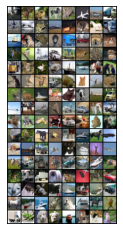

Model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14     

RuntimeError: ignored

In [27]:

DATASET_NAME = 'cifar10'
MODEL = net.to(torch.cuda.current_device())
 
# TODO
OPTIMIZER =  torch.optim.Adam(MODEL.parameters(), lr=1e-5)  
BATCH_SIZE = 128  
NUM_EPOCHS = 200 

trained_model, loss_and_accuracy_history = training_and_eval(DATASET_NAME, 
                                                             MODEL,
                                                             OPTIMIZER,
                                                             BATCH_SIZE, 
                                                             NUM_EPOCHS,
                                                             augment = False)

Files already downloaded and verified
Files already downloaded and verified
Dataset: cifar10 
 Image shape: (3, 32, 32) 
 Number of train images: 50000 
 Number of test images: 10000 
 Number of classes: 10 



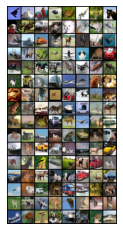

In [28]:
train, test = load_and_preprocess_data("cifar10", BATCH_SIZE)

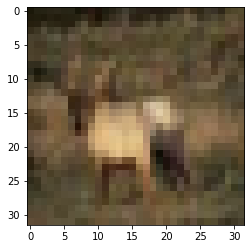

In [29]:
plt.imshow((train.dataset.data[3]/256))

In [30]:
train.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [38]:
train.dataset.data[1]/256

array([[[0.6015625 , 0.69140625, 0.73046875],
        [0.4921875 , 0.53515625, 0.53125   ],
        [0.41015625, 0.40625   , 0.37109375],
        ...,
        [0.35546875, 0.37109375, 0.27734375],
        [0.33984375, 0.3515625 , 0.27734375],
        [0.30859375, 0.31640625, 0.2734375 ]],

       [[0.546875  , 0.625     , 0.66015625],
        [0.56640625, 0.59765625, 0.6015625 ],
        [0.48828125, 0.48828125, 0.4609375 ],
        ...,
        [0.375     , 0.38671875, 0.3046875 ],
        [0.30078125, 0.3125    , 0.2421875 ],
        [0.27734375, 0.28515625, 0.23828125]],

       [[0.546875  , 0.60546875, 0.640625  ],
        [0.54296875, 0.5703125 , 0.58203125],
        [0.44921875, 0.44921875, 0.4375    ],
        ...,
        [0.30859375, 0.3203125 , 0.25      ],
        [0.265625  , 0.2734375 , 0.21484375],
        [0.26171875, 0.26953125, 0.21484375]],

       ...,

       [[0.68359375, 0.65234375, 0.6484375 ],
        [0.609375  , 0.6015625 , 0.625     ],
        [0.6015625 , 0

In [49]:
params = MODEL.parameters()

TypeError: ignored

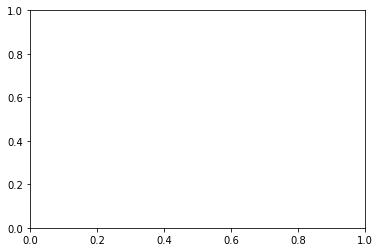

In [42]:
plt.hist(params)

In [58]:
for p in MODEL.parameters(recurse=True):
    print(type(p), p.shape)
    #print(np.array(p.cpu().detach().numpy()))

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 128, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([256, 